## Webscraping example 1: TESCO website

In [1]:
%matplotlib inline

In [24]:
# Some importing 
import re
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

The URL we are trying to scrape is https://www.tesco.com/groceries/en-GB/shop/fresh-food/chilled-fruit-juice-and-smoothies/all

In [5]:
URL = 'https://www.tesco.com/groceries/en-GB/shop/fresh-food/chilled-fruit-juice-and-smoothies/all'

### Getting the content of a webpage

Web scraping can be done in several programming languages: Python, R, Java etc.
The main thing you need it's a library which can access the internet, basically that is able to send HTTP requests.

In Python we have a library call [requests](http://docs.python-requests.org/en/master/)

We then need a parser (mostly to make our lives easier) which transforms the returned content by the requests library in a structure (a tree structure) which then we can access to retrieve elements

In [6]:
def get_content(url):
    try:
        response = requests.get(url)
    except:
        print("Ops! Something went wrong!")
        return None

    if response.status_code == 200:
        html_doc = response.text
        return BeautifulSoup(html_doc, 'html.parser')

    return None

In [9]:
html = get_content(URL)
html

<!DOCTYPE html>
<html class="no-js" data-app-banner-cookie="{}" data-app-name="prd" data-assets='{"/service-worker.js":"/groceries/service-worker.js","/scripts/dtm-helper-async.js":"/groceries/scripts/dtm-helper-async-526ab45895.js","/scripts/oo_engine.min.js":"/groceries/scripts/oo_engine-5ae2b8b829.min.js","/scripts/oo_conf_inline.js":"/groceries/scripts/oo_conf_inline-7ef0f337b7.js","/dfp/dfp.html":"/groceries/dfp/dfp-beaa1a3b14.html","/images/cogs.png":"/groceries/images/cogs.png","/images/sadphone.png":"/groceries/images/sadphone.png","/images/default-image.png":"/groceries/images/default-image.png"}' data-base-path="groceries" data-consumer="default" data-csrf-token="1cZ2TGFl-v8OIRskwLFdd_x1v0TeRKcO7AUA" data-device='{"isStockAndroid":false,"isOldAndroid":false,"isOldIE":false,"deviceType":"desktop","browserType":"Python Requests","operatingSystem":"Other"}' data-environment="container" data-external-secure-domain="https://secure.tesco.com" data-features='{"forceFallbackHomePageD

### Getting the products details in the page

#### Things to look at:

* chack the webpage structure
* find patterns in the naming of the containers for the item
* understand the pagination structure

In [10]:
def get_product(el):

    product = dict()

    title = el.find('a', attrs={'class': 'product-tile--title product-tile--browsable'})
    if title:
        product['product-tile'] = title.text
    else:
        product['product-tile'] = ''

    price = el.find('div', attrs={'class': 'price-control-wrapper'})
    if price:
        product['price'] = float(price.text.replace("£", ""))
    else:
        product['price'] = np.nan

    ppw = el.find('div', attrs={'class': 'price-per-quantity-weight'})
    if ppw:
        product['price-per-quantity-weight'] = ppw.text
    else:
        product['price-per-quantity-weight'] = ''

    return product

In [11]:
def get_elements(page):
    ul = page.find('ul', attrs={'class': 'product-list grid'})
    if ul:
        lis = ul.find_all('li', attrs={'class': re.compile('^product-list--list-item')})
        items = []
        for li in lis:
            items.append(get_product(li))
        return items
    return []

In [12]:
get_elements(html)

[{'price': 0.79,
  'price-per-quantity-weight': '£0.08/100ml',
  'product-tile': 'Tesco Pure Orange Juice Smooth 1 Litre'},
 {'price': 1.29,
  'price-per-quantity-weight': '£0.13/100ml',
  'product-tile': 'Tesco 100% Pure Orange Juice Smooth 1 Litre'},
 {'price': 1.29,
  'price-per-quantity-weight': '£0.13/100ml',
  'product-tile': 'Tesco 100% Pressed Apple Juice 1 Litre'},
 {'price': 0.79,
  'price-per-quantity-weight': '£0.08/100ml',
  'product-tile': 'Tesco Pure Apple Juice 1 Litre'},
 {'price': 1.29,
  'price-per-quantity-weight': '£0.13/100ml',
  'product-tile': 'Tesco 100% Pure Squeezed Orange Juice With Bits 1 Litre'},
 {'price': 2.99,
  'price-per-quantity-weight': '£0.42/100ml',
  'product-tile': 'Innocent Kids Strawberries Raspberries 4 Pack'},
 {'price': 2.48,
  'price-per-quantity-weight': '£0.26/100ml',
  'product-tile': 'Tropicana Orange Juice Smooth 950 Ml'},
 {'price': 1.35,
  'price-per-quantity-weight': '£0.07/100ml',
  'product-tile': 'Tesco Pure Orange Juice Smooth 

## Putting all together: handling pagination

In [13]:
def get_data(url):

    products = []

    # First page
    html = get_content(URL)
    buttons = html.find_all('li', attrs={'class': 'pagination-btn-holder'})
    last = int(buttons[-2].text[0])

    products.extend(get_elements(html))

    # Get everything
    for i in range(1, last):
        content = get_content(URL + '?page=' + str(i+1))
        products.extend(get_elements(content))

    return products

In [14]:
p = get_data(URL)

## Putting the data in a dataframe

In [15]:
df = pd.DataFrame(p)
df.head()

,price,price-per-quantity-weight,product-tile
0,0.79,£0.08/100ml,Tesco Pure Orange Juice Smooth 1 Litre
1,1.29,£0.13/100ml,Tesco 100% Pure Orange Juice Smooth 1 Litre
2,1.29,£0.13/100ml,Tesco 100% Pressed Apple Juice 1 Litre
3,0.79,£0.08/100ml,Tesco Pure Apple Juice 1 Litre
4,1.29,£0.13/100ml,Tesco 100% Pure Squeezed Orange Juice With Bit...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
price                        149 non-null float64
price-per-quantity-weight    150 non-null object
product-tile                 150 non-null object
dtypes: float64(1), object(2)
memory usage: 3.6+ KB


In [26]:
df.price.describe()

count    149.00000
mean       2.08302
std        0.80753
min        0.70000
25%        1.29000
50%        2.00000
75%        2.50000
max        3.99000
Name: price, dtype: float64

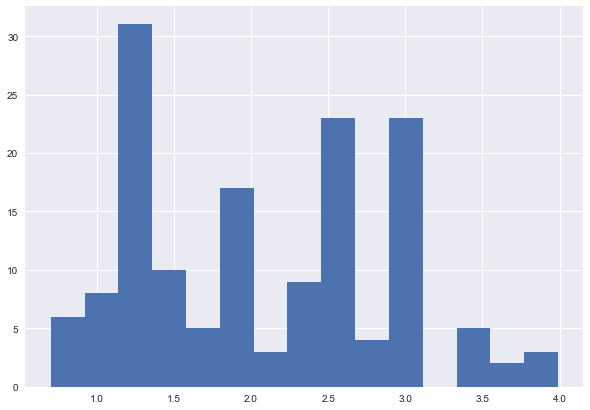

In [25]:
df.price.hist(bins=15, figsize=(10,7))